In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

import dlc_bci as bci
from dlc_practical_prologue import *

import torch
from torch import nn
from torch.nn import functional as F
from torch.autograd import Variable

### Load dataset

In [25]:
tr_input, tr_target = bci.load("bci", train=True, one_khz=True)
te_input, te_target = bci.load("bci", train=False, one_khz=True)
tr_target = convert_to_one_hot_labels(tr_input, tr_target)
te_target = convert_to_one_hot_labels(te_input, te_target)

### Standardize

In [54]:
samples = tr_input[0:10]

In [55]:
samples.shape

torch.Size([10, 28, 500])

In [57]:
sample = samples[0,0,:]

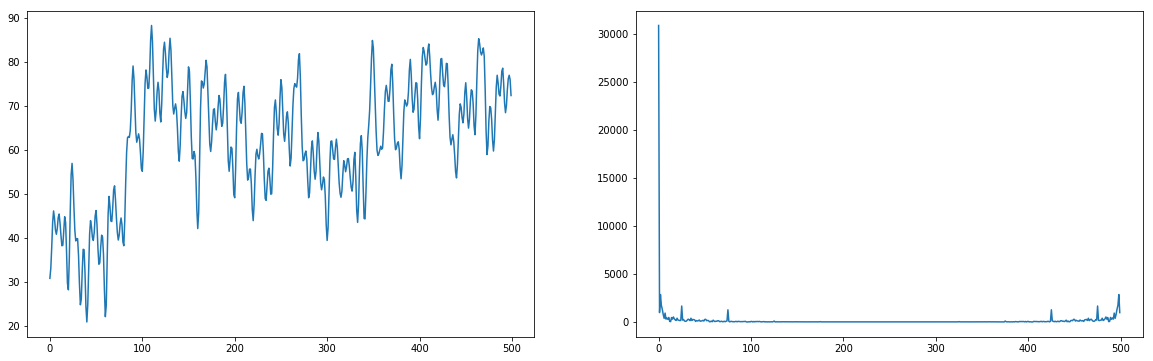

In [80]:
sample = samples[0,0,:]
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,6))
ax1.plot(sample.numpy())
ax2.plot(abs(np.fft.fft(sample)))
plt.show()

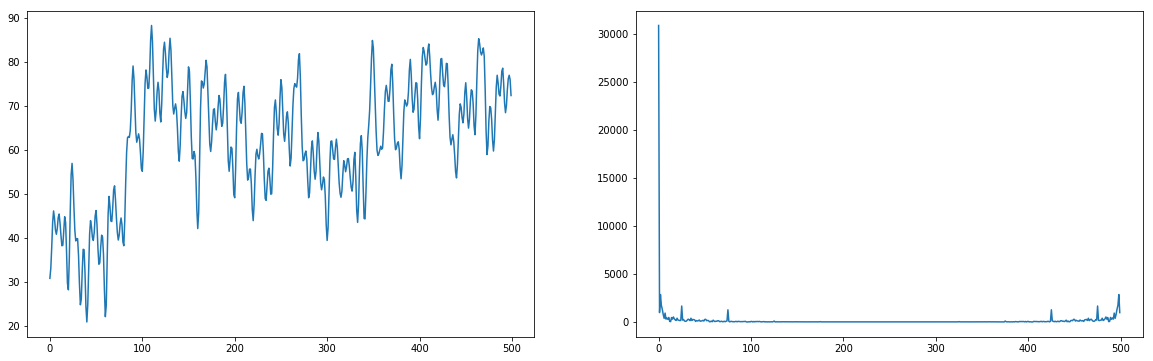

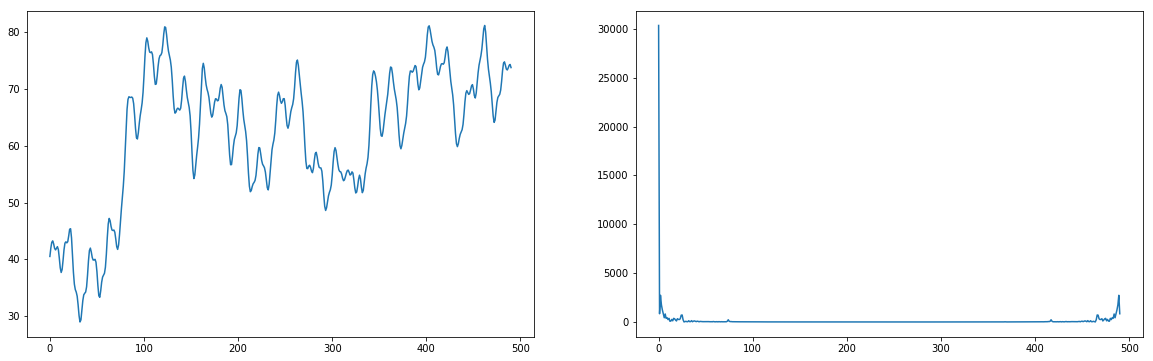

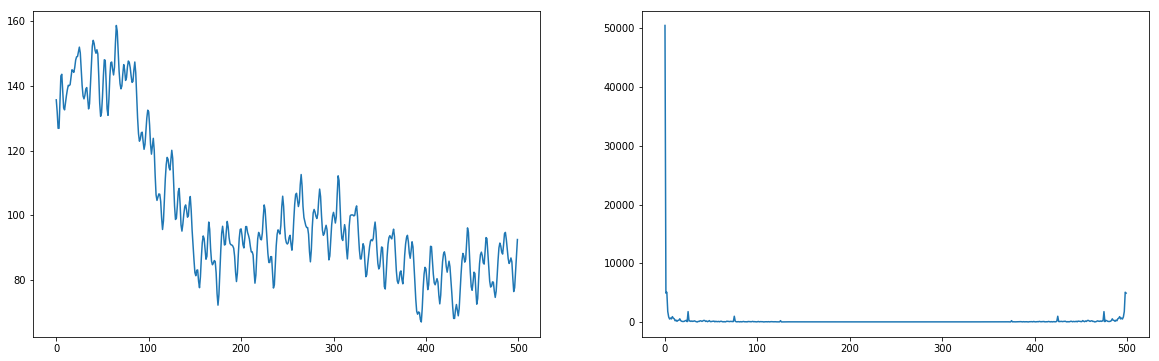

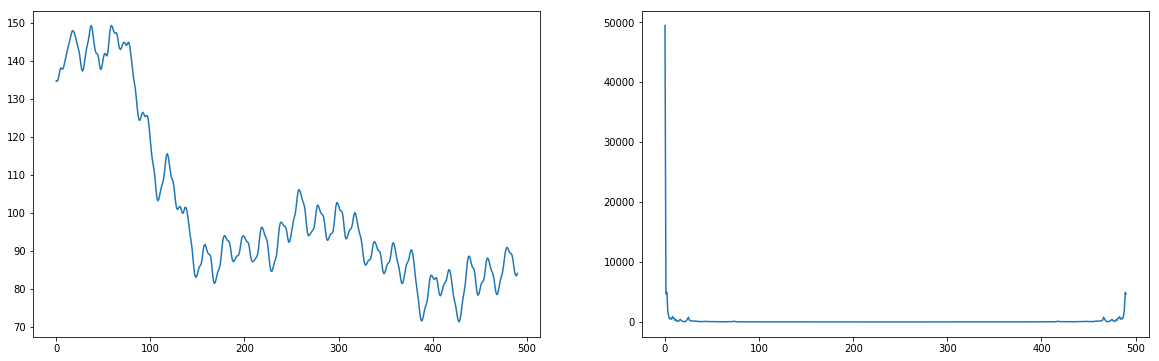

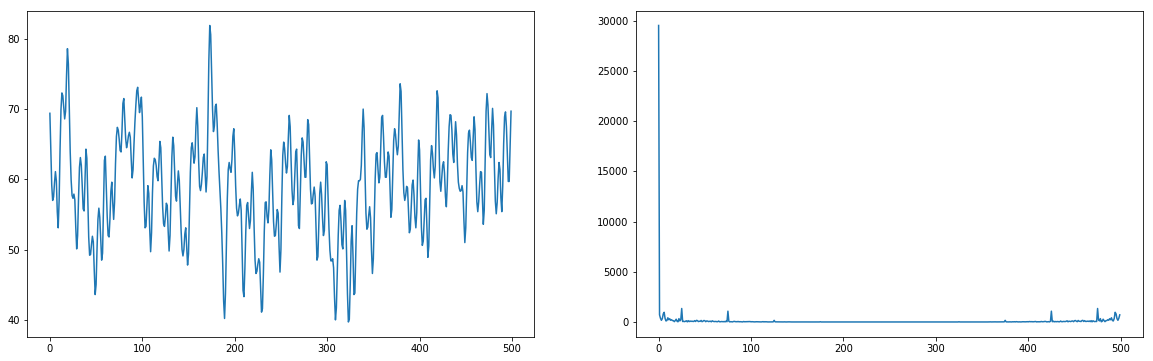

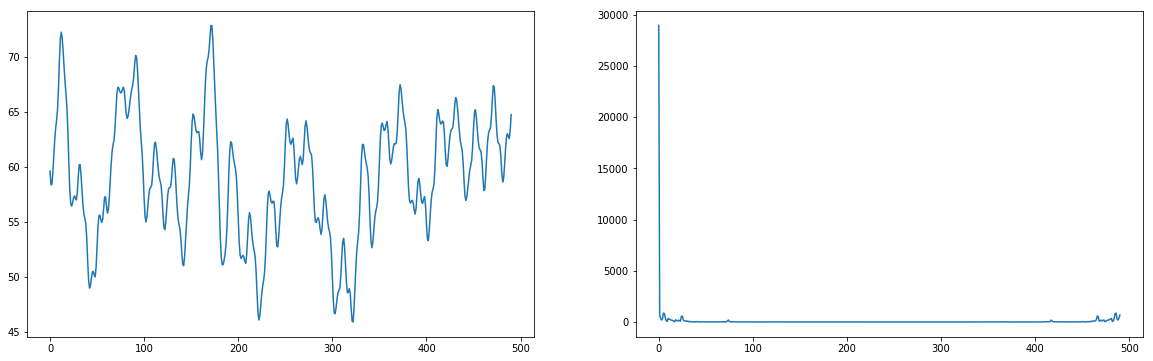

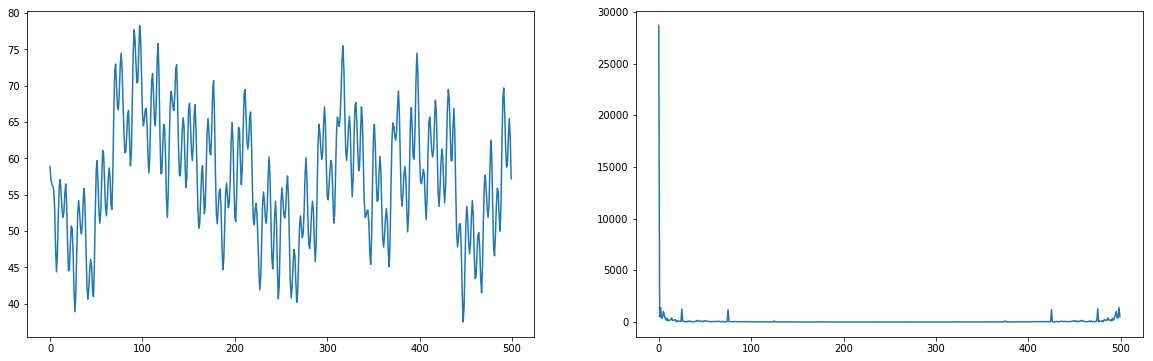

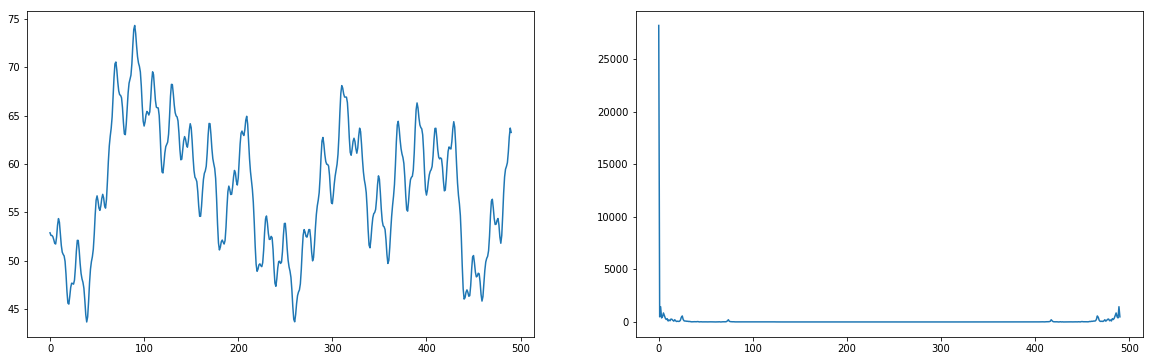

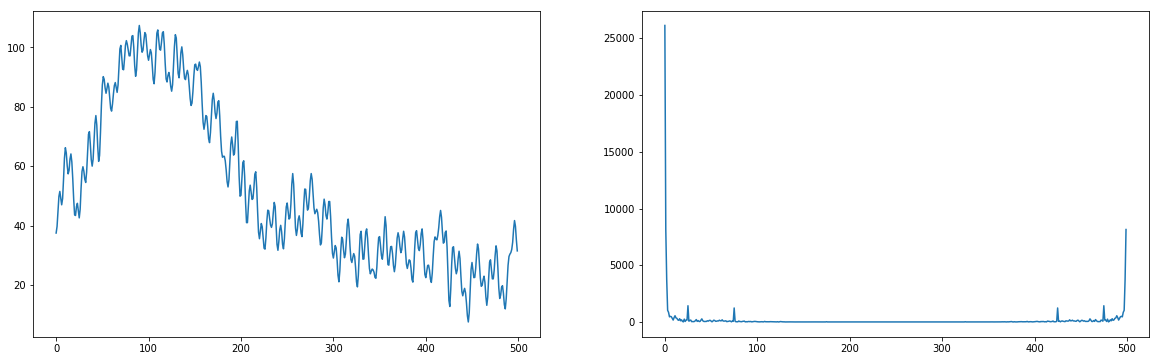

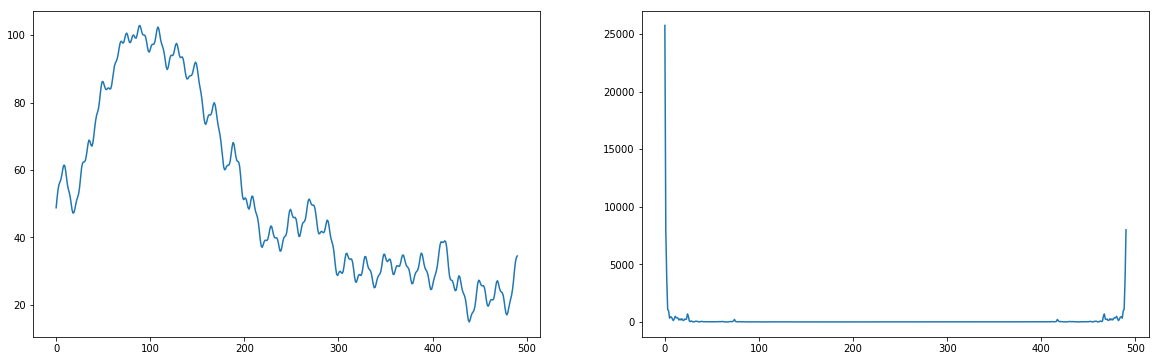

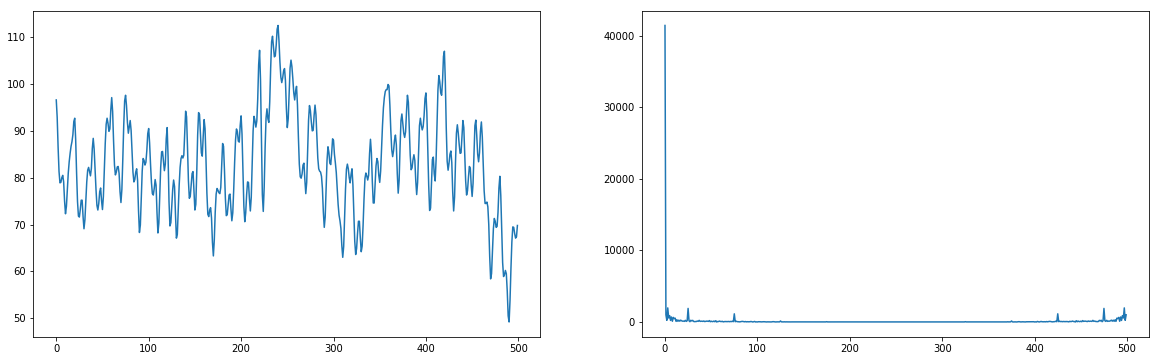

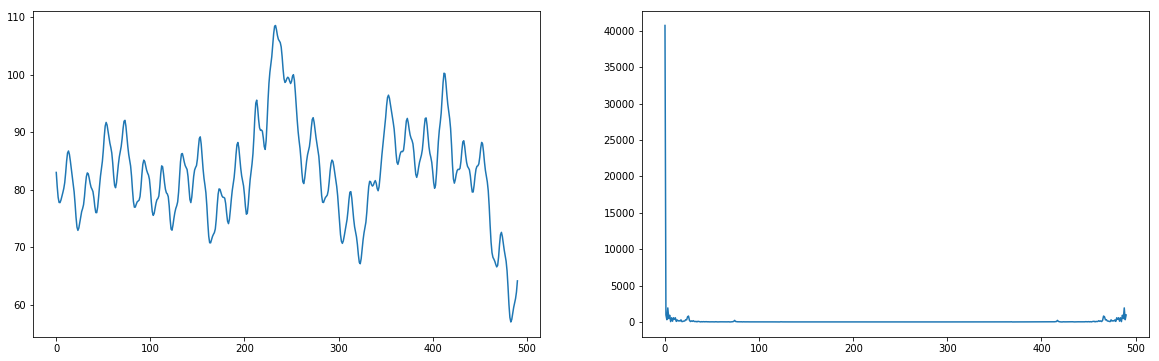

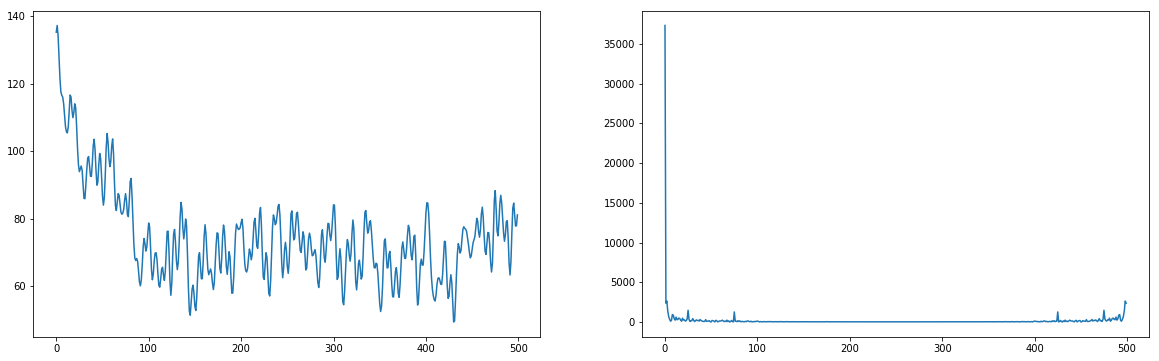

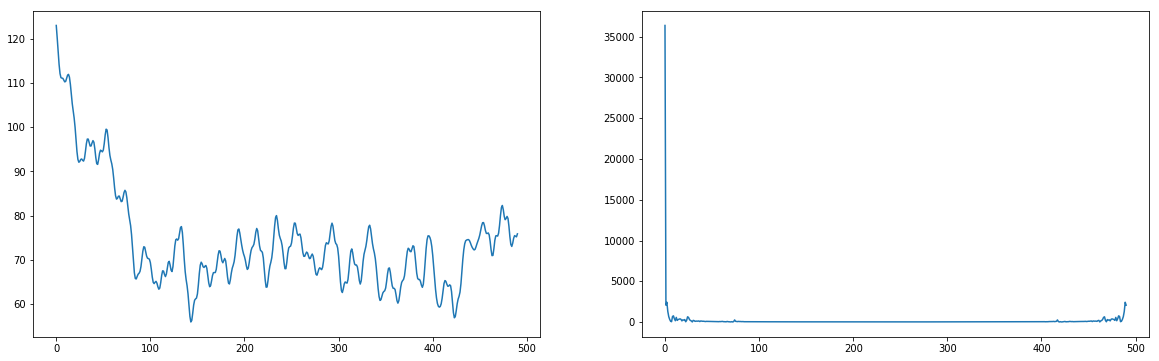

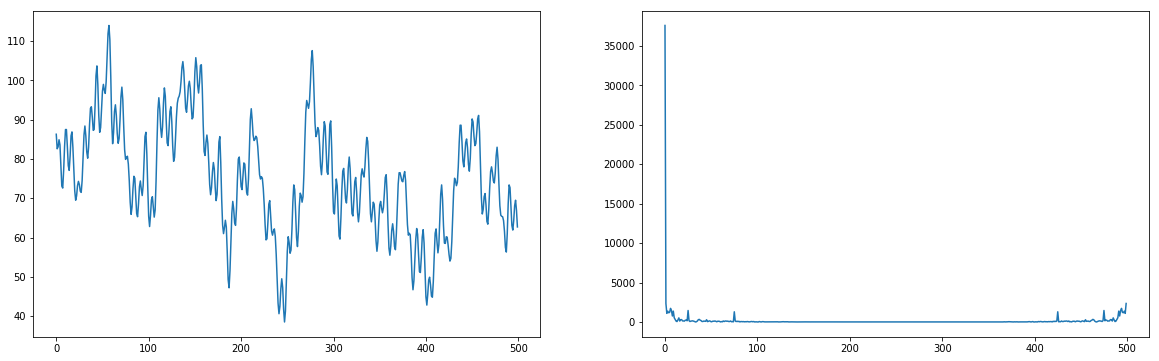

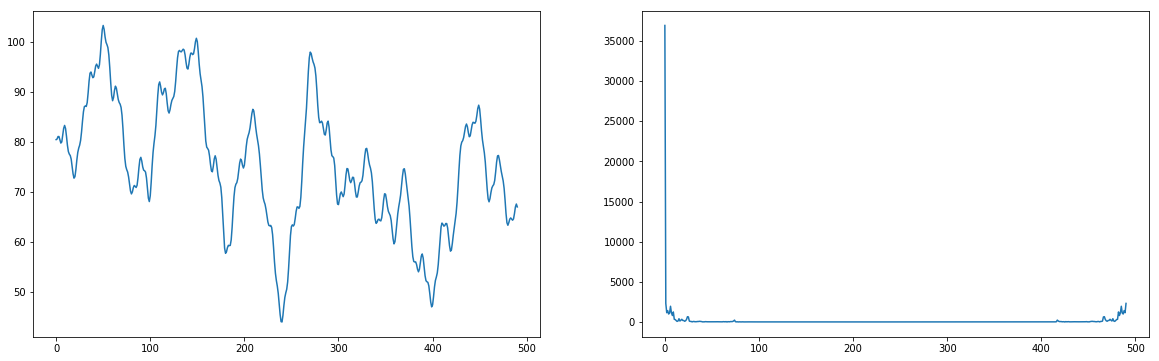

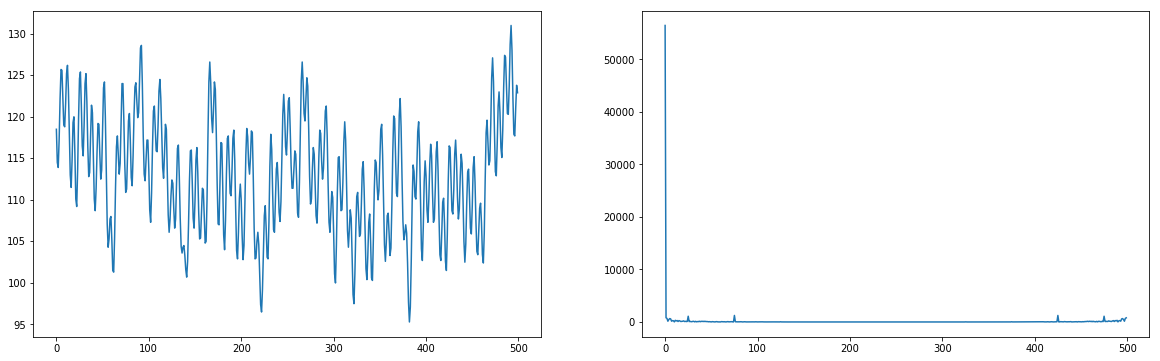

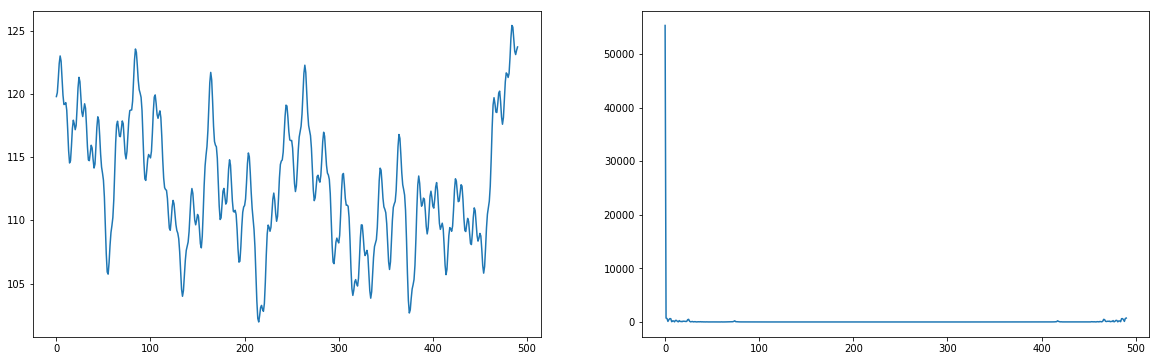

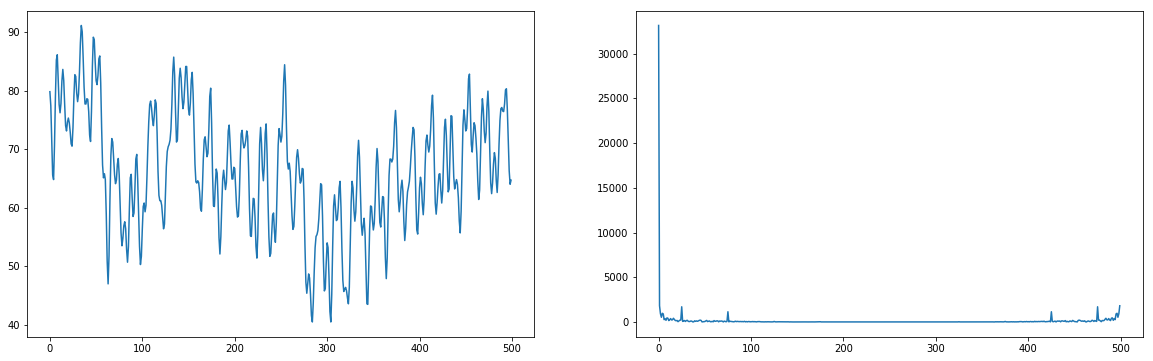

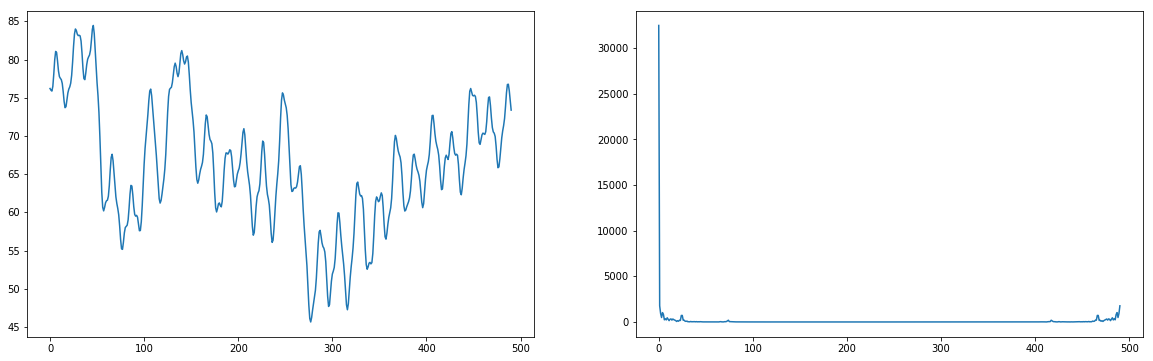

In [90]:

for sample in samples:
    sample = sample[0,:]
#     sample = samples[0,0,:]
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,6))
    ax1.plot(sample.numpy())
    ax2.plot(abs(np.fft.fft(sample)))
    plt.show()

    N = 10
    sample_filtered = np.convolve(sample, np.ones((N,))/N, mode='valid')

    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,6))
    ax1.plot(sample_filtered)
    ax2.plot(abs(np.fft.fft(sample_filtered)))
    plt.show()

In [18]:
tr_input = torch.nn.functional.normalize(tr_input, p=2, dim=0) 
te_input = torch.nn.functional.normalize(te_input, p=2, dim=0) 

tr_input, tr_target = Variable(tr_input.view(-1,28*500)), Variable(tr_target)
te_input, te_target = Variable(te_input.view(-1,28*500)), Variable(te_target)

In [19]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28 * 500, 500)
        self.fc2 = nn.Linear(500, 500)
        self.fc3 = nn.Linear(500, 2)
        
    def forward(self, x, mode=False):
        x = F.relu(self.fc1(x))
        x = F.dropout(x, p=0.5)
        x = F.relu(self.fc2(x))
        x = F.dropout(x, p=0.5)
        x = self.fc3(x)
        return x

In [5]:
# construct and train model
model = Net()
tr_loss, te_loss = bci.train_model(model, tr_input, tr_target, 4, te_input, te_target, 4, 50)
torch.save(model.state_dict(), os.getcwd() + "v1.pth")

# compute train and test errors
nb_tr_errors = bci.compute_nb_errors(model, tr_input, tr_target, 4)
nb_te_errors = bci.compute_nb_errors(model, te_input, te_target, 4)

print('tr error {:0.2f}% {:d}/{:d}'.format((100 * nb_tr_errors) / tr_input.size(0), nb_tr_errors, tr_input.size(0)))
print('te error {:0.2f}% {:d}/{:d}'.format((100 * nb_te_errors) / te_input.size(0), nb_te_errors, te_input.size(0)))

epoch 0 tr loss 79.41 te loss 25.08
epoch 1 tr loss 79.12 te loss 25.07
epoch 2 tr loss 78.89 te loss 25.06
epoch 3 tr loss 78.64 te loss 25.06
epoch 4 tr loss 78.34 te loss 25.08
epoch 5 tr loss 77.95 te loss 25.11
epoch 6 tr loss 77.47 te loss 25.18
epoch 7 tr loss 76.87 te loss 25.29
epoch 8 tr loss 76.19 te loss 25.51
epoch 9 tr loss 75.40 te loss 25.89
epoch 10 tr loss 74.51 te loss 26.45
epoch 11 tr loss 73.61 te loss 27.21
epoch 12 tr loss 72.68 te loss 28.11
epoch 13 tr loss 71.73 te loss 29.12
epoch 14 tr loss 70.73 te loss 30.20
epoch 15 tr loss 69.64 te loss 31.29
epoch 16 tr loss 68.48 te loss 32.30
epoch 17 tr loss 67.21 te loss 33.43
epoch 18 tr loss 65.79 te loss 34.66
epoch 19 tr loss 64.31 te loss 36.03
epoch 20 tr loss 62.75 te loss 37.54
epoch 21 tr loss 61.09 te loss 39.24
epoch 22 tr loss 59.24 te loss 41.25
epoch 23 tr loss 57.39 te loss 43.26
epoch 24 tr loss 55.42 te loss 45.05
epoch 25 tr loss 53.51 te loss 46.72
epoch 26 tr loss 51.63 te loss 48.25
epoch 27 tr

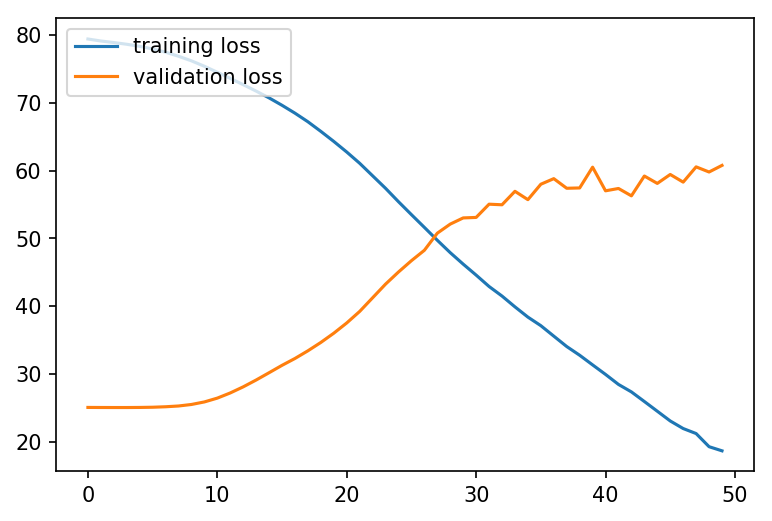

In [6]:
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 150

plt.figure()
plt.plot(tr_loss, label='training loss')
plt.plot(te_loss, label='validation loss')
plt.legend(loc='upper left')